In [ ]:
import numpy as np
import pandas as pd
from pulp import LpProblem, LpMaximize, LpVariable, lpSum, LpBinary
import matplotlib.pyplot as plt

In [ ]:
# CSV 파일 로드
d_data = pd.read_csv(r'C:\Users\82102\OneDrive\첨부 파일\경희대학교\강의\3-1\물류관리\물류관리_텀프\processed_data\p_median_d_variable.csv')  # 거리 데이터 파일
h_data = pd.read_csv(r'C:\Users\82102\OneDrive\첨부 파일\경희대학교\강의\3-1\물류관리\물류관리_텀프\processed_data\real_p_median_h_variable.csv')  # 수요 데이터 파일

In [ ]:
# 거리 및 수요 데이터 추출
h_values = h_data['val'].values  # 수요량 (h_i) 추출
num_candidates = len(d_data.columns) - 2  # 후보지지 개수 계산 (grid와 geometry 제외)
d_matrix = d_data.iloc[:, 1:num_candidates + 1].values  # 거리 행렬 추출 (d_ij)

# 한계 거리 (300m)
distance_threshold = 300  # 300m in meters

# 커버리지 행렬 생성
coverage = {
    (i, j): 1 if d_matrix[i, j] <= distance_threshold else 0
    for i in range(len(h_values))
    for j in range(num_candidates)
}

p = 1, Facilities Opened: [3], Total Covered Demand: 4.140557196839651
p = 2, Facilities Opened: [3, 20], Total Covered Demand: 8.197681275471094
p = 3, Facilities Opened: [1, 3, 20], Total Covered Demand: 12.139392652286693
p = 4, Facilities Opened: [1, 3, 6, 20], Total Covered Demand: 16.049470358195716
p = 5, Facilities Opened: [1, 3, 6, 10, 20], Total Covered Demand: 19.37170816742484
p = 6, Facilities Opened: [1, 2, 3, 6, 10, 20], Total Covered Demand: 22.672765820454558
p = 7, Facilities Opened: [1, 2, 3, 6, 10, 20, 27], Total Covered Demand: 25.88614109388649
p = 8, Facilities Opened: [1, 2, 3, 6, 10, 19, 20, 27], Total Covered Demand: 29.06436472994622
p = 9, Facilities Opened: [1, 2, 3, 6, 10, 13, 19, 20, 27], Total Covered Demand: 31.89268021193279
p = 10, Facilities Opened: [0, 1, 2, 3, 6, 10, 13, 19, 20, 27], Total Covered Demand: 34.503456006139984


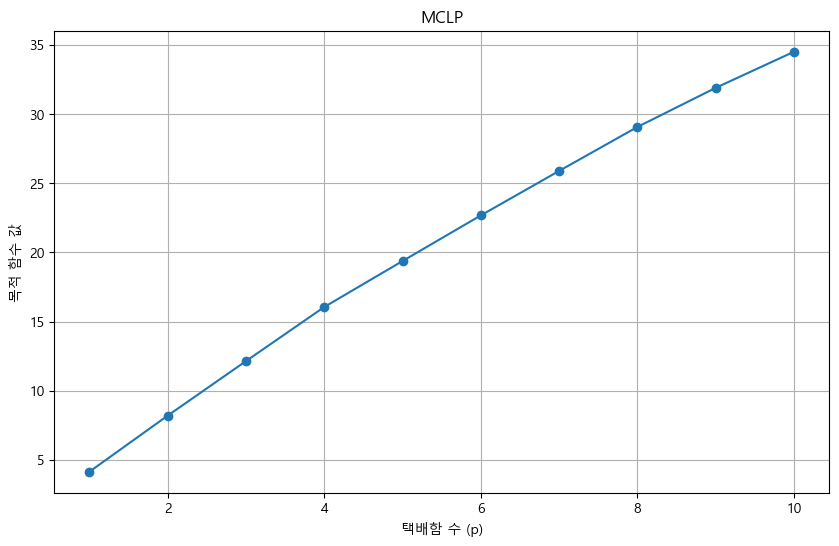

In [ ]:
# MCLP 최적화 함수 정의
def solve_mclp(p):
    # 최적화 문제 정의
    prob = LpProblem("MCLP", LpMaximize)

    # 결정 변수 정의
    x = LpVariable.dicts("x", range(num_candidates), cat=LpBinary)  # 후보 노드의 시설 설치 여부
    z = LpVariable.dicts("z", range(len(h_values)), cat=LpBinary)  # 수요 지점 커버 여부

    # 목적 함수: 커버된 총 수요 최대화
    prob += lpSum(h_values[i] * z[i] for i in range(len(h_values)))

    # 제약 조건 정의
    # 1. 수요 지점은 커버 범위 내에 설치된 시설이 있어야 커버 가능
    for i in range(len(h_values)):
        prob += z[i] <= lpSum(x[j] for j in range(num_candidates) if coverage[i, j] == 1), f"Cover_{i}"

    # 2. 설치할 시설의 총 개수는 p로 제한됨
    prob += lpSum(x[j] for j in range(num_candidates)) <= p, "FacilityLimit"

    # 문제 풀이
    prob.solve()

    # 결과 추출
    selected_facilities = [j for j in range(num_candidates) if x[j].varValue == 1]
    total_covered_demand = sum(h_values[i] for i in range(len(h_values)) if z[i].varValue == 1)

    return selected_facilities, total_covered_demand

# 실험: p 값을 1부터 10까지 변경하며 결과 저장
results = []
p_values = range(1, 11)  # p = 1 ~ 10
for p in p_values:
    facilities, covered_demand = solve_mclp(p)
    results.append((p, facilities, covered_demand))
    print(f"p = {p}, Facilities Opened: {facilities}, Total Covered Demand: {covered_demand}")

# 결과 시각화
covered_demand = [result[2] for result in results]  # 커버된 총 수요량

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(10, 6))
plt.plot(p_values, covered_demand, marker='o', linestyle='-')
plt.title("MCLP")
plt.xlabel("택배함 수 (p)")
plt.ylabel("목적 함수 값")
plt.grid(True)
plt.show()